<a href="https://colab.research.google.com/github/Aryaman2912/ML/blob/master/MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries and packages
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

In [2]:
# Methods and functions necessary
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict
from sklearn.base import clone
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix,precision_score,recall_score,precision_recall_curve,roc_curve,roc_auc_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Fetch dataset
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
# X is the set of images and y is the set of labels
X,y = mnist["data"],mnist['target']
y = y.astype(np.uint8)             # Convert y from string to int 
print(X.shape,'\n',y.shape)

(70000, 784) 
 (70000,)


5

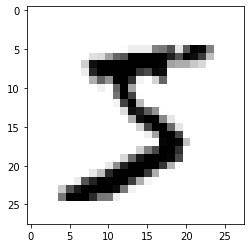

In [5]:
# Display an image
digit = X[0]
digit_pic = digit.reshape(28,28)
plt.imshow(digit_pic,cmap = mpl.cm.binary,interpolation="nearest") 
y[0]

In [6]:
# Train test split
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [7]:
# Binary classifier to classify each image as 5 or not 5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
print(sgd_clf.predict([digit]))

# Cross validation
# skfolds = StratifiedKFold(n_splits=3,random_state=42)

# for train_index,test_index in skfolds.split(X_train,y_train_5):
#   clone_clf = clone(sgd_clf)
#   X_train_folds = X_train[train_index]
#   y_train_folds = y_train_5[train_index]
#   X_test_fold = X_train[test_index]
#   y_test_fold = y_train_5[test_index]

#   clone_clf.fit(X_train_folds,y_train_folds)
#   y_pred = clone_clf.predict(X_test_fold)
#   n_correct = sum(y_pred == y_test_fold)
#   print(n_correct/len(y_pred))

# sklearn function for cross validation score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy',verbose=1,n_jobs=-1)


[ True]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.8s finished


array([0.95035, 0.96035, 0.9604 ])

In [8]:
# Confusion matrix to evaluate performance. It is better than using accuracy as a parameter
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,verbose=1,n_jobs=-1)
y_train_pred.shape
conf_mx = confusion_matrix(y_train_5,y_train_pred)
print(conf_mx)
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[[53892   687]
 [ 1891  3530]]
0.8370879772350012
0.6511713705958311


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.9s finished


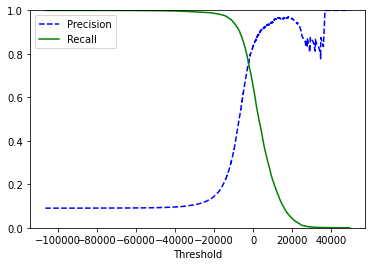

In [9]:
# Precision vs Recall
def plot_precision_vs_recall(precisions,recalls,thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
  plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.ylim([0,1])

y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function',verbose=1,n_jobs=-1)
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)
plot_precision_vs_recall(precisions,recalls,thresholds)
plt.show()

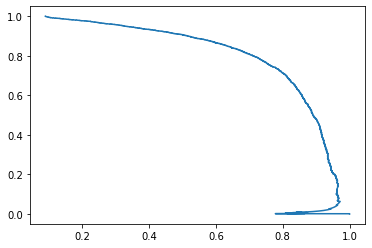

In [10]:
# There is a tradeoff between precision and recall. When one rises, the other falls
plt.plot(precisions,recalls)

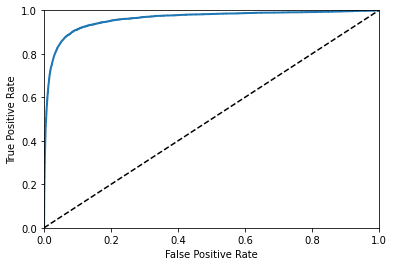

0.9604938554008616

In [11]:
# ROC curve
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)
plot_roc_curve(fpr,tpr)
plt.show() 
roc_auc_score(y_train_5,y_scores)   # Higher the better

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   54.0s finished


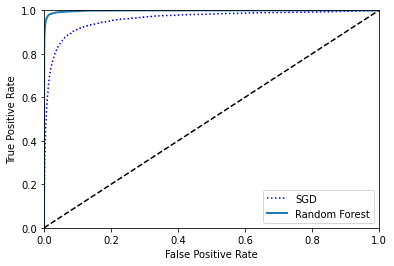

In [12]:
# Random forest binary classifier(5 or not 5)

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba",verbose=1,n_jobs=-1)
y_scores_forest = y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [13]:
# Random forest classifier performs better than SGD classifier
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

#Multiclass Classification

In [14]:
# SGD classifier for multi class classification with cross validation scores
sgd_clf = SGDClassifier(random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train) 
print(cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy",verbose=1,n_jobs=-1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[0.8983 0.891  0.9018]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.1min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.1min finished


[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


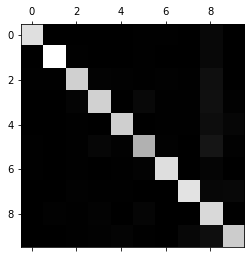

In [15]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3,verbose=2,n_jobs=-1)
conf_mx = confusion_matrix(y_train,y_train_pred)          # conf_mx[i][j] = number of i's that were predicted as j
print(conf_mx)
plt.matshow(conf_mx,cmap = plt.cm.gray)
plt.show()

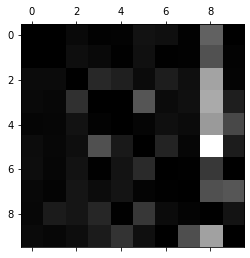

In [16]:
# Plot error rates instead of absolute number of errors
row_sums = conf_mx.sum(axis=1,keepdims=True)
# print(row_sums)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0)        # Fill diagonal elements with 0 as they represent true positives only
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()
# Lot of images are falsely classified as 8

#Multilabel Classification

In [22]:
# Classifier to predict if the number is greater than 6 and odd
y_train_large = (y_train > 6)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)
knn_clf.predict([digit])
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3,verbose=2,n_jobs=-1)
f1_score(y_multilabel,y_train_knn_pred,average='macro')      # f1 score is the harmonic mean of precision and recall

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 54.7min finished


0.976410265560605

In [20]:
# f1_score(y_multilabel,y_train_knn_pred)
knn_clf.predict([digit])

array([[False,  True]])